# Practical Activity 1 (**PRA1**)

## Evaluable Practical Exercise

<u>General considerations</u>:

- The proposed solution cannot use methods, functions or parameters declared **_deprecated_** in future versions.
- This activity must be carried out on a **strictly individual** basis. Any indication of copying will be penalized with a failure for all parties involved and the possible negative evaluation of the subject in its entirety.
- It is necessary for the student to indicate **all the sources** that she/he has used to carry out the PRA. If not, the student will be considered to have committed plagiarism, being penalized with a failure and the possible negative evaluation of the subject in its entirety.

<u>Delivery format</u>:

- Some exercises may require several minutes of execution, so the delivery must be done in **Notebook format** and in **HTML format**, where the code, results and comments of each exercise can be seen. You can export the notebook to HTML from the menu File $\to$ Download as $\to$ HTML.
- There is a special type of cell to hold text. This type of cell will be very useful to answer the different theoretical questions posed throughout the activity. To change the cell type to this type, in the menu: Cell $\to$ Cell Type $\to$ Markdown.

<div class="alert alert-block alert-info">
<strong>Name and surname: Martina Carretta</strong>
</div>

## Introduction

Blackjack environment is part of the Gymnasium's [Toy Text](https://gymnasium.farama.org/environments/toy_text/) environments. Blackjack is a card game where the goal is to beat the dealer by obtaining cards that sum to closer to 21 (without going over 21) than the dealer's cards.

The game starts with the dealer having one face up and one face down card, while the player has two face up cards. All cards are drawn from an infinite deck (i.e. with replacement).

The card values are, as depicted in the following figure:
- Face cards (Jack, Queen, King) have a point value of **10**.
- Aces can either count as **11** (called a ``usable ace'') or **1**.
- Numerical cards (**2-9**) have a value equal to their number.

<img src="./figs/BlackJackCards.png" />

The player has the sum of cards held. The player can request additional cards (**hit**) until they decide to stop (**stick**) or exceed 21 (**bust**, immediate loss).

After the player sticks, the dealer reveals their face down card, and draws cards until their sum is 17 or greater. If the dealer goes bust, the player wins.

If neither the player nor the dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.

Further information could be found at:
- Gymnasium [Blackjack](https://gymnasium.farama.org/environments/toy_text/blackjack/)

In order to initialize the environment, we will use `natural=True` to give an additional reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21), as depicted in the following piece of code:

In [43]:
import gymnasium as gym

env = gym.make('Blackjack-v1', natural=True, sab=False)

In [44]:
print("Action space is {} ".format(env.action_space))
print("Observation space is {} ".format(env.observation_space))
print("Reward range is {} ".format(env.reward_range))
print("hi")

Action space is Discrete(2) 
Observation space is Tuple(Discrete(32), Discrete(11), Discrete(2)) 
Reward range is (-inf, inf) 
hi


## Part 1. Naïve Policy

Implement an agent that carries out the following deterministic policy: 
- The agent will **stick** if it gets a score of 20 or 21.
- Otherwise, it will **hit**.

<u>Questions</u> (**1 point**): 
1. Using this agent, simulate 100,000 games and calculate the agent's return (total accumulated reward).
2. Additionally, calculate the % of wins, natural wins, losses and draws. 
3. Comment on the results.

In [45]:
import collections

class Agent:
    def __init__(self, env):
        self.env = env
        self.state = self.env.reset()[0]
        self.rewards = collections.defaultdict(float)
        self.transits = collections.defaultdict(collections.Counter)
        self.values = collections.defaultdict(float)


    def select_action(self, state) -> int:
        score = self.calculate_score(state)
        if score == 20 or score == 21:
            return 0
        else:
            return 1
        

    def calculate_score(self, state) -> int:
        player_sum, dealer_card, usable_ace = state
        return player_sum


    def play_episode(self, env) -> float:
        total_reward = 0.0
        state, _ = env.reset()

        while True:
            action = self.select_action(state)
            new_state, reward, terminated, truncated, _ = env.step(action)
            is_done = terminated or truncated
            if is_done:
                total_reward = reward # only compute once since the reward is only given at the end -1, 0, or 1
                break
            state = new_state
        return total_reward
    
agent = Agent(env)


In [46]:
num_games = 100000

total_reward = 0.0

for _ in range(num_games):
    total_reward += agent.play_episode(env)

print(f"Total accumulated reward: {total_reward}")

Total accumulated reward: -33120.5


In [47]:
# Calculate statistics
num_games = 100000
wins = 0
natural_wins = 0
losses = 0
draws = 0

for _ in range(num_games):
    state, _ = agent.env.reset()
    episode_reward = 0.0
    while True:
        action = agent.select_action(state)
        new_state, reward, terminated, truncated, _ = agent.env.step(action)
        is_done = terminated or truncated
        episode_reward += reward
        if is_done:
            if reward == 1.0 or reward == 1.5: # Normal and natural wins
                wins += 1
                if state[0] == 21 and state[2]:  # Natural win is a counted both as a win and a natural win
                    natural_wins += 1
            elif reward == -1.0:
                losses += 1
            else:
                draws += 1
            break
        state = new_state

win_percentage = (wins / num_games) * 100
natural_win_percentage = (natural_wins / num_games) * 100
loss_percentage = (losses / num_games) * 100
draw_percentage = (draws / num_games) * 100

print(f"Win percentage: {win_percentage}%")
print(f"Natural win percentage: {natural_win_percentage}%")
print(f"Loss percentage: {loss_percentage}%")
print(f"Draw percentage: {draw_percentage}%")

Win percentage: 29.360000000000003%
Natural win percentage: 5.378%
Loss percentage: 64.804%
Draw percentage: 5.836%


<span style="color: lightblue;">

Answer: For the moment it has a low win rate, an even lower draw rate and most of the games are losses. there are only 5000 out of 100000 games were won with a natural win (meaning that the ace was used as an 11 value card). this is quite normal taking into account that it means the player has been handed an Ace (only 4 in the whole car deck making it a 0'07%) and a 10, Jack, Queen, or King (16). Being handed a card with a value of 10 has about a 30% porbability. This means that being handed an ace AND a 10-value card is quite improbable, so it's normal to have only a few natural wins
</span>

## Part 2. Monte Carlo method

The objective of this section is to estimate the optimal policy using Monte Carlo methods. Specifically, you can choose and implement one of the algorithms related to _Control using MC methods_ (with ''exploring starts'' or without ''exploring starts'', both on-policy or off-policy).

<u>Questions</u> (**2.5 points**): 
1. Implement the selected algorithm and justify your choice.
2. Comment and justify all the parameters, such as:
- Number of episodes
- Discount factor
- Etc.
3. Implement a function that prints on the screen the optimal policy found for each state (similar to the figure in Section 3.1).
4. Using the trained agent, simulate 100,000 games and calculate the agent's return (total accumulated reward).
5. Additionally, calculate the % of wins, natural wins, losses and draws.

<span style="color: lightblue;">

Answer: Exploring starts means that every possible state-action pair has a chance of being explored at least one. In Blackjack, it's not realistic to start with any pair of state-action. For example, it would be unrealistic to start the game with a pair of hards with sum value 20. 

MonteCarlo off-policy (whihc means that there are two policies, one to generate the episode and one that will be optimized) has a higher variance and the advantage it has is that it can add external knowledge. However, for the BlackJack game, it is not necessary since it will learn throught the policy creation phase what is a good action in each state

</span>

In [48]:
import numpy as np
from collections import defaultdict
import sys

def make_epsilon_greedy_policy(Q, epsilon, num_Actions):
    def policy_fn(observation):
        A = np.ones(num_Actions, dtype=float) * epsilon / num_Actions #array with number of actions. Equation from the notes
        best_action = np.argmax(Q[observation]) 
        A[best_action] += (1.0 - epsilon)

        return A
    return policy_fn

def mc_control_on_policy_epsilon_greedy(env, num_episodes, discount=1.0, epsilon=0.1, epsilon_decay = 0.999):

    # We store the sum and number of returns for each state to calculate the average. 
    # We could use an array to store all the returns, but it is inefficient in terms of memory.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The Q action value function.
    # A nested dictionary whose correspondence is state -> (action -> action-value).
    # Initially we initialize it to zero
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(1, num_episodes + 1):
        # The policy we are following
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        
        # We print which episode we are in, useful for debugging.
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # We generate an episode and store it
        # An episode is an array of tuples (state, action, reward)
        episode = []
        state, _ = env.reset()
        done = False
        while not done:
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs) # choose one accoridng to the probability distribution
            next_state, reward, done, _, _ = env.step(action)
            episode.append((state, action, reward)) # add tuple with state, action and reward. we concatenate all timesteps until the end. 
            if done:
                break
            state = next_state
        
        G = 0
        # for each time step
        for state, action, reward in episode[::-1]:
            sa_pair = (state, action)
            
            # We add up all the rewards since the first appearance
            G = reward + discount * G
            
            # We calculate the average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
        # The policy is implicitly improved by changing the values of Q
        epsilon = max(epsilon_decay*epsilon, 0.01)

    
    return Q, policy

In [49]:
Q, policy = mc_control_on_policy_epsilon_greedy(env, num_episodes=500000, discount=1, epsilon=0.8)

Episode 500000/500000

In [50]:
import pandas as pd

data = []
for state in Q.keys():
    action_probabilities = policy(state)
    data.append({'State': state, 'Policy': action_probabilities})

df = pd.DataFrame(data) # I put it in a dataframe to make it easier to display

# Display only the first 10 rows
df.head(10)


,State,Policy
0,"(18, 10, 0)","[0.995, 0.005]"
1,"(16, 7, 0)","[0.005, 0.995]"
2,"(20, 2, 0)","[0.995, 0.005]"
3,"(9, 10, 0)","[0.005, 0.995]"
4,"(17, 7, 0)","[0.995, 0.005]"
5,"(11, 6, 0)","[0.005, 0.995]"
6,"(15, 6, 0)","[0.995, 0.005]"
7,"(13, 10, 0)","[0.005, 0.995]"
8,"(12, 3, 0)","[0.005, 0.995]"
9,"(16, 3, 0)","[0.995, 0.005]"


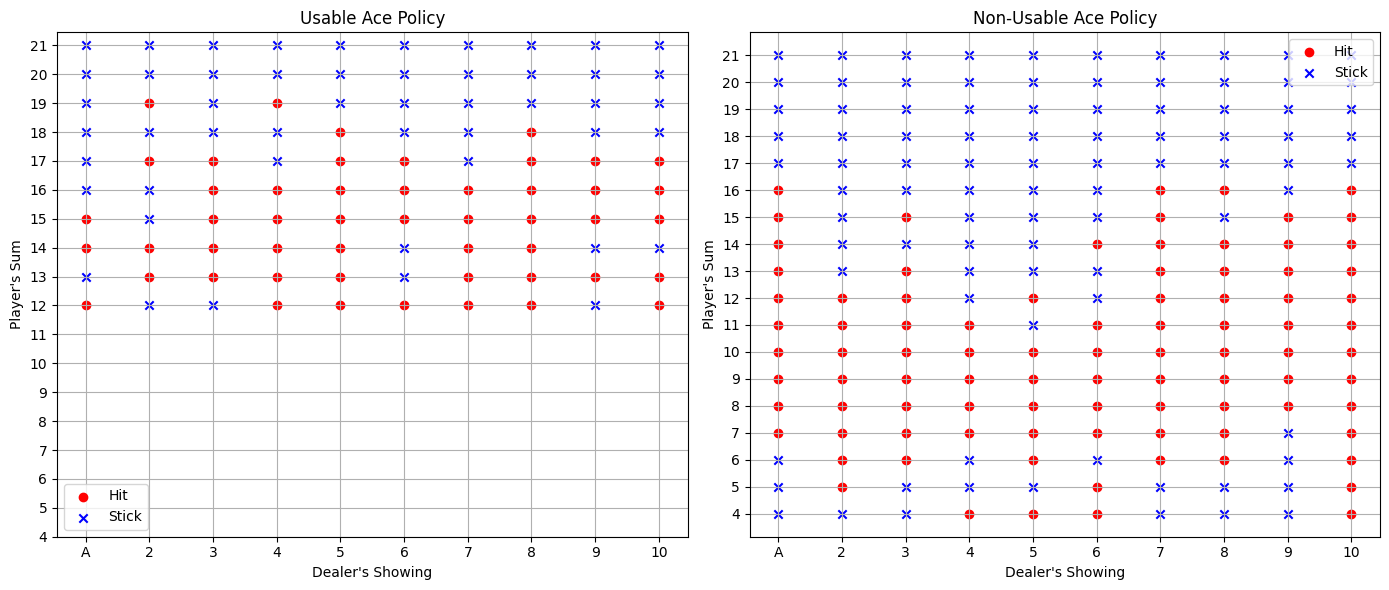

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def plot_policy(Q, policy):
    # Separate lists for usable and non-usable ace cases
    hit_player_sums_usable = []
    hit_dealer_showings_usable = []
    stick_player_sums_usable = []
    stick_dealer_showings_usable = []

    hit_player_sums_non_usable = []
    hit_dealer_showings_non_usable = []
    stick_player_sums_non_usable = []
    stick_dealer_showings_non_usable = []

    # Separate the states into hit and stick regions for usable and non-usable ace cases
    for state, policy in Q.items():
        player_sum, dealer_showing, usable_ace = state
        if usable_ace:  # Usable ace case
            if policy[0] > policy[1]:  # Stick if stick probability is higher
                stick_player_sums_usable.append(player_sum)
                stick_dealer_showings_usable.append(dealer_showing)
            else:  # Hit if hit probability is higher
                hit_player_sums_usable.append(player_sum)
                hit_dealer_showings_usable.append(dealer_showing)
        else:  # Non-usable ace case
            if policy[0] > policy[1]:  # Stick if stick probability is higher
                stick_player_sums_non_usable.append(player_sum)
                stick_dealer_showings_non_usable.append(dealer_showing)
            else:  # Hit if hit probability is higher
                hit_player_sums_non_usable.append(player_sum)
                hit_dealer_showings_non_usable.append(dealer_showing)

    # Create two subplots: one for usable ace and one for non-usable ace
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot for usable ace
    axs[0].scatter(hit_dealer_showings_usable, hit_player_sums_usable, color='red', label='Hit', marker='o')
    axs[0].scatter(stick_dealer_showings_usable, stick_player_sums_usable, color='blue', label='Stick', marker='x')
    axs[0].set_title("Usable Ace Policy")
    axs[0].set_xlabel("Dealer's Showing")
    axs[0].set_ylabel("Player's Sum")
    axs[0].set_xticks(np.arange(1, 11))
    axs[0].set_xticklabels(['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])  # Dealer cards
    axs[0].set_yticks(np.arange(4, 22))  # Player sums from 4 to 21
    axs[0].grid(True)
    axs[0].legend()

    # Plot for non-usable ace
    axs[1].scatter(hit_dealer_showings_non_usable, hit_player_sums_non_usable, color='red', label='Hit', marker='o')
    axs[1].scatter(stick_dealer_showings_non_usable, stick_player_sums_non_usable, color='blue', label='Stick', marker='x')
    axs[1].set_title("Non-Usable Ace Policy")
    axs[1].set_xlabel("Dealer's Showing")
    axs[1].set_ylabel("Player's Sum")
    axs[1].set_xticks(np.arange(1, 11))
    axs[1].set_xticklabels(['A', '2', '3', '4', '5', '6', '7', '8', '9', '10'])  # Dealer cards
    axs[1].set_yticks(np.arange(4, 22))  # Player sums from 4 to 21
    axs[1].grid(True)
    axs[1].legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

plot_policy(Q, policy)


<span style="color: lightblue;">

I have used chatGPT to help me construct the image to show the policy
</span>

In [52]:
def run_episodes_and_get_stats (num_games, q, env, debug, discount, epsilon):
    wins = 0
    natural_wins = 0
    losses = 0
    draws = 0

    for _ in range(num_games):
        obs, _ = agent.env.reset()
        if debug:
            print("Obs initial: {}".format(obs))

        episode_reward = 0.0
        while True:
            # Choose an action following the optimal policy (no epsilon greedy)
            arr = np.array(q[obs])
            action = arr.argmax()

            # execute the action and wait for the response from the environment
            new_obs, reward, terminated, truncated, _ = env.step(action)
            if debug:
                print("Action: {} -> Obs:{} and reward: {}".format(action, new_obs, reward))

            done = terminated or truncated

            obs = new_obs
            episode_reward += reward

            if done:
                if reward == 1.0 or reward == 1.5: # Normal and natural wins
                    wins += 1
                    if state[0] == 21 and state[2]:  # Natural win is a counted both as a win and a natural win
                        natural_wins += 1
                elif reward == -1.0:
                    losses += 1
                else:
                    draws += 1
                break

    win_percentage = (wins / num_games) * 100
    natural_win_percentage = (natural_wins / num_games) * 100
    loss_percentage = (losses / num_games) * 100
    draw_percentage = (draws / num_games) * 100

    if num_games > 1: # For the trial i don't need the stats. I add this if so that it doesn't print and i know it's only for the trial and it's working. 
        print()
        if epsilon:
            print(f"Number of games: {num_games}, discount: {discount}, epsilon: {epsilon}")
        else:
            print(f"Number of games: {num_games}, discount: {discount}")
            
        print(f"   Win percentage: {win_percentage}%")
        print(f"   Natural win percentage: {natural_win_percentage}%")
        print(f"   Loss percentage: {loss_percentage}%")
        print(f"   Draw percentage: {draw_percentage}%")

In [53]:
# Trial:
run_episodes_and_get_stats(num_games=1, q=Q, env=env, debug=True, discount=1, epsilon=0.8)

Obs initial: (9, 1, 0)
Action: 1 -> Obs:(19, 1, 0) and reward: 0.0
Action: 0 -> Obs:(19, 1, 0) and reward: 1.0


In [54]:
run_episodes_and_get_stats (num_games=100000, q=Q, env=env, debug=False, discount=1, epsilon=0.8)

# Change epsilon to 0.9
Q, policy = mc_control_on_policy_epsilon_greedy(env, num_episodes=100000, discount=1, epsilon=1)
run_episodes_and_get_stats (num_games=100000, q=Q, env=env, debug=False, discount=1, epsilon=1)


Number of games: 100000, discount: 1, epsilon: 0.8
   Win percentage: 42.181999999999995%
   Natural win percentage: 0.0%
   Loss percentage: 48.693%
   Draw percentage: 9.125%
Episode 100000/100000
Number of games: 100000, discount: 1, epsilon: 1
   Win percentage: 40.815%
   Natural win percentage: 0.0%
   Loss percentage: 51.599%
   Draw percentage: 7.585999999999999%


In [55]:
def mc_control_on_policy_epsilon_greedy_every_visit(env, num_episodes, discount=1.0, epsilon=0.1, epsilon_decay=0.9):
    """
    Control by Monte Carlo methods using Epsilon-Greedy policies
    Find an epsilon-greedy policy.
    
    Args:
         env: Gymnasium environment.
         num_episodes: Number of episodes in the sample.
         discount: discount factor.
         epsilon: The probability of selecting a random action (float between 0 and 1)
    
    Returns:
         A tuple (Q, policy).
         Q: A dictionary whose correspondence is state -> action-values.
         policy: A function that takes the observation as an argument and returns as a result
                 the probabilities of each action
    """
    
    # We store the sum and number of returns for each state to calculate the average. 
    # We could use an array to store all the returns, but it is inefficient in terms of memory.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The Q action value function.
    # A nested dictionary whose correspondence is state -> (action -> action-value).
    # Initially we initialize it to zero
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Rewards
    y = np.zeros(num_episodes, dtype=np.float16)
    
    for i_episode in range(num_episodes):
        # The policy we are following
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        
        # We update epsilon
        epsilon = max(epsilon * epsilon_decay, 0.01)

        # We generate an episode and store it
        # An episode is an array of tuples (state, action, reward)
        episode = []
        state, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode.append((state, action, reward))
            total_reward += reward
            if done:
                break
            state = next_state

        y[i_episode] = total_reward
        idx = 0
        
        # We visited all the states of the episode
        G = 0
        for i in range(len(episode)-1, -1, -1):
            x = episode[i]
            state = x[0]
            action = x[1]
            reward = x[2]
            sa_pair = (state, action)
            # We calculate the return of each state
            G = reward + discount * G
            # We calculate the average return for this state across all sampled episodes.   
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
            idx = idx + 1
        
        # We print which episode we are in, useful for debugging.
        if i_episode % 100 == 0 and i_episode > 0:
            print("\rEpisode {:8d}/{:8d} - Average reward {:.2f}".format(i_episode, num_episodes, np.average(y[(i_episode-100):i_episode])), end="")
            sys.stdout.flush()
            
        # The policy is implicitly improved by changing the values of Q
    
    return Q, policy

Q, policy = mc_control_on_policy_epsilon_greedy_every_visit(env, num_episodes=100000, discount=1, epsilon=1, epsilon_decay=0.999)

Episode      100/  100000 - Average reward -0.34

Episode    99900/  100000 - Average reward -0.01

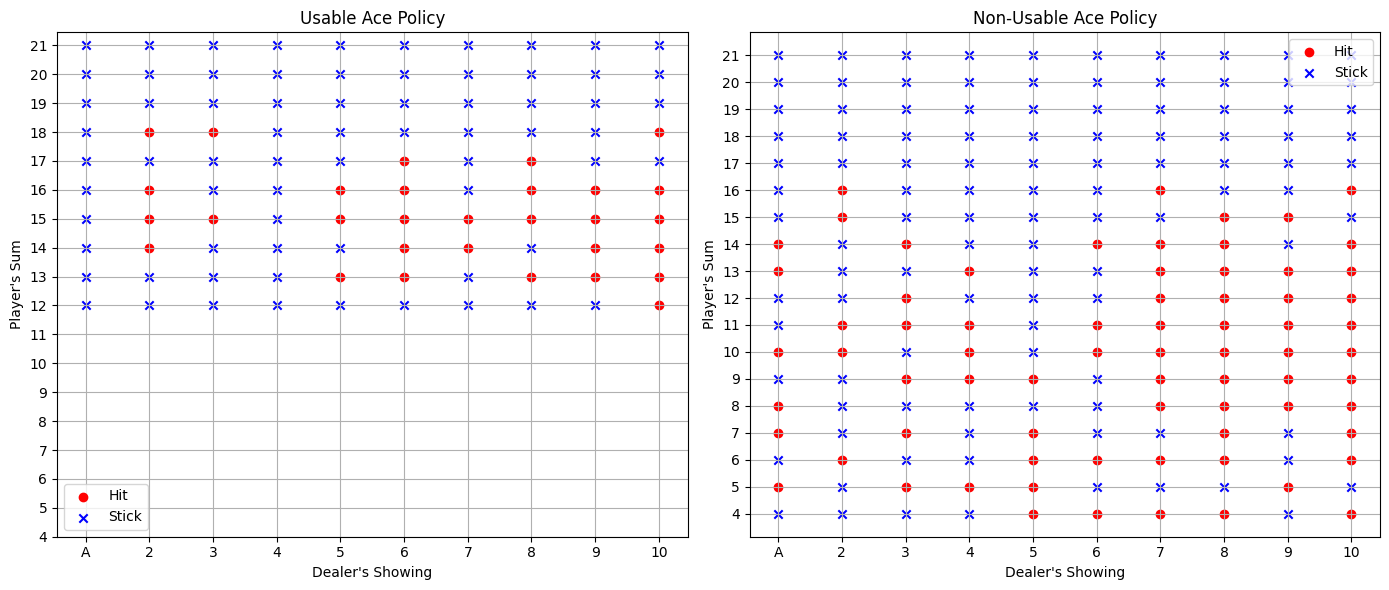

In [56]:
plot_policy(Q, policy)

In [57]:
run_episodes_and_get_stats (num_games=100000, q=Q, env=env, debug=False, discount=1, epsilon=1)


Number of games: 100000, discount: 1, epsilon: 1
   Win percentage: 41.288000000000004%
   Natural win percentage: 0.0%
   Loss percentage: 50.32299999999999%
   Draw percentage: 8.389000000000001%


<span style="color: lightblue;">

I'm going to try Monte Carlo with exploring starts
</span>

Episode 200/500000

Episode 500000/500000

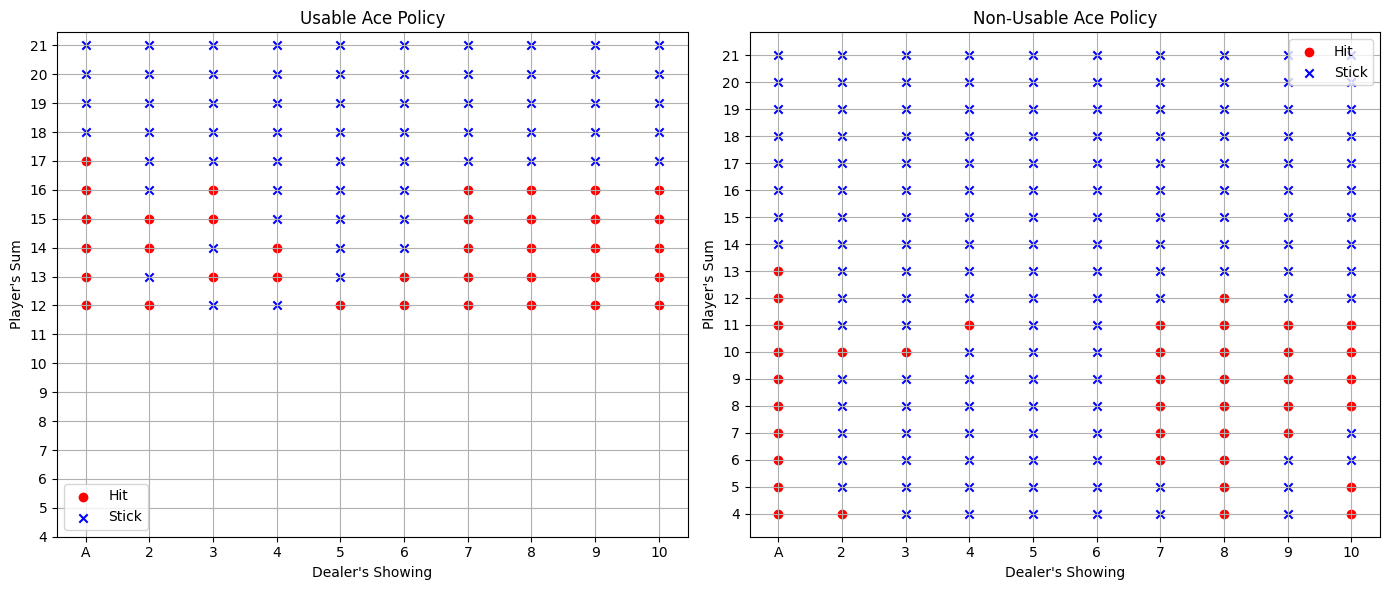

In [58]:
def mc_control_exploring_starts(env, num_episodes, discount=1.0, epsilon=0.1):

    # We store the sum and number of returns for each state to calculate the average. 
    # We could use an array to store all the returns, but it is inefficient in terms of memory.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    # The Q action value function.
    # A nested dictionary whose correspondence is state -> (action -> action-value).
    # Initially we initialize it to zero
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(1, num_episodes + 1):
        # We print which episode we are in, useful for debugging.
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # Generate an episode
        state, _ = env.reset()
        action = np.random.choice(np.arange(env.action_space.n)) # Start with random aaction
        
        episode = []
        done = False

        while not done:
            next_state, reward, done, _, _ = env.step(action)
            episode.append((state, action, reward))
            
            if not done:
                if np.random.rand() < epsilon:
                    action = np.random.choice(np.arange(env.action_space.n))
                else:
                    action = np.argmax(Q[next_state]) # Choose the best action according to the Q function computed with the policy
            state = next_state
        
        G = 0
        for state, action, reward in reversed(episode):
            sa_pair = (state, action)

            G = reward + discount * G

            # Update the returns_sum and returns_count
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

    # The greedy policy is implicitly improved by using the updated Q values
    def greedy_policy(state):
        """Returns the greedy action for a given state based on Q values."""
        return np.argmax(Q[state])
    
    return Q, greedy_policy

Q, policy = mc_control_exploring_starts(env, 500000, discount=1, epsilon=1)
plot_policy(Q, policy)

In [59]:
run_episodes_and_get_stats (num_games=100000, q=Q, env=env, debug=False, discount=1, epsilon=1)


Number of games: 100000, discount: 1, epsilon: 1
   Win percentage: 41.214%
   Natural win percentage: 0.0%
   Loss percentage: 52.093999999999994%
   Draw percentage: 6.691999999999999%


## Part 3. TD learning

The objective of this section is to estimate the optimal policy using TD learning methods. Specifically, you have to implement the SARSA algorithm.

<u>Questions</u> (**2.5 points**): 
1. Implement the algorithm.
2. Comment and justify all the parameters.
3. Print on the screen the optimal policy found for each state.
4. Using the trained agent, simulate 100,000 games and calculate the agent's return (total accumulated reward).
5. Additionally, calculate the % of wins, natural wins, losses and draws.

## Part 4. Comparison of the algorithms

In this section, we will make a comparison among the algorithms.

We will compare the performance of the algorithms when changing the number of episodes, the discount factor and the *learning rate* values (in the case of the SARSA method).

For each exercise, the results must be presented and justified.

**Note**: 
- It is recommended to run the simulations multiple times for each exercise, as these are random, and to comment on the most frequent result or the average of these.

### 4.1. Comparison to the optimal policy

The optimal policy for this problem, described by [Sutton & Barto](http://incompleteideas.net/book/the-book-2nd.html) is depicted in the following image:

<img src="./figs/optimal.png" style="width: 800px;" />

<u>Questions</u> (**1 point**): 
- Compare the _optimal_ policies of the naïve, Monte Carlo and SARSA methods to the optimal one provided by Sutton & Barto.
- Comment on the results and justify your answer. 

### 4.2. Influence of the Number of Episodes

Conduct a study by varying the number of episodes in each of the algorithms.

<u>Questions</u> (**1 point**): 
- Train each algorithm multiple times with 100,000, 1,000,000, and 5,000,000 episodes and average the results.
- Indicate how the **number of episodes** influences the convergence of each algorithm by calculating the number of states where the policy differs from the optimal one, as well as the average return obtained after playing 100,000 games following each training.

### 4.3. Influence of the Discount Factor

Conduct a study by varying the *discount factor* in each of the algorithms.

<u>Questions</u> (**1 point**):
- Run the algorithms with *discount factor* = 0.1, 0.5, 0.9 and the rest of the parameters the same as in previous exercises. 
- Describe the changes in the optimal policy, comparing the result obtained with the result of previous exercises (*discount factor* = 1).

### 4.4. Influence of the Learning Rate

Conduct a study by varying the learning rate in the *SARSA* algorithm.

<u>Questions</u> (**1 point**):
- Run the *SARSA* algorithm with the following *learning rate* values: 0.001, 0.01, 0.1, and 0.9.
- Analyze the differences with the results obtained previously in terms of the number of errors relative to the optimal policy and the accumulated reward for every 100,000 episodes played.